In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#import statsmodels.api as sm
#import statsmodels.stats.api as sms
#import statsmodels.formula.api as smf
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, roc_curve

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, './src')

import data_clean as dclean

In [3]:
df_orig = pd.read_csv('data/creditcard.csv')

In [4]:
df_orig.shape

(284807, 31)

In [5]:
dclean.check_nan(df_orig, df_orig.columns)

Dataframe total row count:  284807
There are 0 columns with nan/null values


In [6]:
for c in df_orig.columns:
    dclean.check_zero(df_orig, c)

Column Time : 2 rows are 0
No 0 values in column V1
No 0 values in column V2
No 0 values in column V3
No 0 values in column V4
No 0 values in column V5
No 0 values in column V6
No 0 values in column V7
No 0 values in column V8
No 0 values in column V9
No 0 values in column V10
No 0 values in column V11
No 0 values in column V12
No 0 values in column V13
No 0 values in column V14
No 0 values in column V15
No 0 values in column V16
No 0 values in column V17
No 0 values in column V18
No 0 values in column V19
No 0 values in column V20
No 0 values in column V21
No 0 values in column V22
No 0 values in column V23
No 0 values in column V24
No 0 values in column V25
No 0 values in column V26
No 0 values in column V27
No 0 values in column V28
Column Amount : 1825 rows are 0
Column Class : 284315 rows are 0


**From the analysis above, we can see that the positive and negative classes are imbalanced**

In [7]:
print 'Positive class percentage: {}%'.format((1.*sum(df_orig['Class']==1)/df_orig.shape[0])*100)

Positive class percentage: 0.172748563062%


In [8]:
X = df_orig[df_orig.drop('Class', axis =1).columns]
y = df_orig['Class']

In [9]:
# Untreated original imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y)

**Use GridSearch to see which C and penalty for LogisticRegression are the best**

In [81]:
# gridsearch.get_params().keys()

In [113]:
scaler = ('scaler', StandardScaler())
model = ('lrclf', LogisticRegression())

steps = [
   # feature,
    scaler,
    model
]

grid = {'lrclf__C':[0.01,0.1,1],
        'lrclf__penalty':['l1','l2']
}

pipeline = Pipeline(steps)
gridsearch = GridSearchCV(pipeline,
                         grid)

gridsearch.fit(X_train, y_train)
best_model = gridsearch.best_estimator_

In [114]:
print "best parameters:", gridsearch.best_params_

best parameters: {'lrclf__C': 1, 'lrclf__penalty': 'l1'}


In [115]:
y_pred = best_model.predict(X_train)
recall_score(y_train, y_pred) 

0.66057441253263705

**The result is pretty bad using original imbalanced data**

**Now try undersample treatment on negative class**

In [10]:
X_undersample, y_undersample = dclean.undersample(X, y)

In [11]:
print 'Positive class percentage: {}%'.format((1.*sum(y_undersample==1)/len(y_undersample))*100)

Positive class percentage: 49.4472361809%


In [12]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_undersample, y_undersample)

In [13]:
scaler = ('scaler', StandardScaler())
model = ('lrclf', LogisticRegression())

steps = [
   # feature,
    scaler,
    model
]

grid = {'lrclf__C':[0.01,0.1,1,10,100],
        'lrclf__penalty':['l1','l2']
}

pipeline = Pipeline(steps)
gridsearch = GridSearchCV(pipeline,
                         grid,
                         scoring='recall')

gridsearch.fit(X_train_us, y_train_us)
best_model = gridsearch.best_estimator_

In [16]:
print "best parameters:", gridsearch.best_params_

best parameters: {'lrclf__C': 100, 'lrclf__penalty': 'l2'}


In [17]:
y_pred = best_model.predict(X_train)
recall_score(y_train, y_pred) 

0.92934782608695654

**After undersample treatment, CV result improved a lot**

**Try tree-based model**

In [61]:
# Grid Search CV for Random Forest
scaler = ('scaler', StandardScaler())
model = ('rfclf', RandomForestClassifier())

steps = [
   # feature,
    scaler,
    model
]
random_forest_grid = {'rfclf__max_depth': [3, None],
                      'rfclf__max_features': ['sqrt', 'log2', None],
                      'rfclf__min_samples_split': [2, 4],
                      'rfclf__min_samples_leaf': [1, 2, 4],
                      'rfclf__bootstrap': [True, False],
                      'rfclf__n_estimators': [100],
                      'rfclf__random_state': [1]}

pipeline = Pipeline(steps)
gridsearch = GridSearchCV(pipeline,
                         random_forest_grid,
                         n_jobs=-1,
                         verbose=True,
                         scoring='recall')

gridsearch.fit(X_train_us, y_train_us)
best_rf_model = gridsearch.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   46.6s finished


In [62]:
y_pred = best_rf_model.predict(X_train)
recall_score(y_train, y_pred)

0.94240837696335078

**Plot the Confusion Matrix**

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Predict for the test data**

Confusion matrix, without normalization
[[67083  4009]
 [    6   104]]


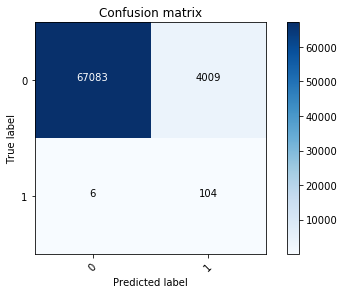

In [45]:
y_pred = best_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix
                      , classes=[0,1]
                      , title='Confusion matrix')
plt.show()

In [46]:
recall_score(y_test, y_pred)

0.94545454545454544

Confusion matrix, without normalization
[[68914  2178]
 [    6   104]]


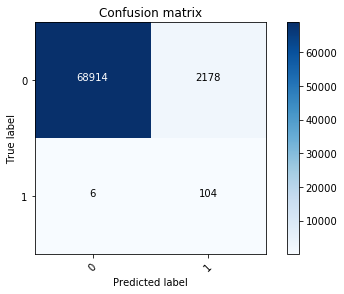

In [43]:
y_pred = best_rf_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix
                      , classes=[0,1]
                      , title='Confusion matrix')
plt.show()

In [44]:
recall_score(y_test, y_pred)

0.94545454545454544

Plotting the ROC curve

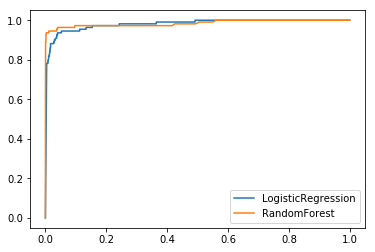

In [49]:
y_pred_prob = best_model.predict_proba(X_test)
y_pred = y_pred_prob[:,-1]
fp, tp, thresholds = roc_curve(y_test, y_pred)
plt.plot(fp, tp, label='LogisticRegression')
y_pred_prob = best_rf_model.predict_proba(X_test)
y_pred = y_pred_prob[:,-1]
fp, tp, thresholds = roc_curve(y_test, y_pred)
plt.plot(fp, tp, label = 'RandomForest')
plt.legend()

## Apply cost-benefit matrix and plot profit curve

In [40]:
df_costM = pd.DataFrame({'Pred T':['$1998','$-2'],'Pred N':['$0','$0']}, index=['Actual T','Actual N'])[['Pred T','Pred N']]

If we set a correctly detected fraud transaction will save the company \$2000, and for each detected "fraud" transaction we reach out to the customer which costs $2 each time. We'll have the cost matrix below: 

In [41]:
df_costM

,Pred T,Pred N
Actual T,$1998,$0
Actual N,$-2,$0


In [53]:
def profit_curve(cost_bene, label, y_pred_prob):
    '''Function to calculate list of profits based on supplied cost-benefit
    matrix and prediced probabilities of data points and thier true labels.
    cost_bene  : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TP | FP |
                                          -----------
                                          | FN | TN |
                                          -----------
    label      : ndarray - 1D, true label of datapoints, 0 or 1
    y_pred_prob : ndarray - 1D, predicted probability for each datapoint
                                    in labels, in range [0, 1]
    thresholds  : list of float, range [0,1]
    '''
    # sort the predicted probs indice descending order if use all sorted threshold to calculate each profit
    # But dues to large data amount, I'm using np.linspace(1, 0.0, 500) to simulate the trend
    #idx = np.argsort(y_pred_prob)[::-1]
    #y_pred_sorted = y_pred_prob[idx]
    #label_sorted = label[idx]
    cum_prof = []
    for t in np.linspace(1, np.min(y_pred_prob), 500):
        y_pred = y_pred_prob >= t
        #y_true = label_sorted
        tp, fp, fn, tn = sum(y_pred & label), sum(y_pred & (label==0)), sum((y_pred==0) & label), sum((y_pred==0) & (label==0))
        #print tp, fp, fn, tn
        prof = 1.*(cost_bene[0][0]*tp + cost_bene[0][1]*fp + cost_bene[1][0]*fn + cost_bene[1][1]*tn)/len(label)
        #print prof
        cum_prof.append(prof)
    return cum_prof

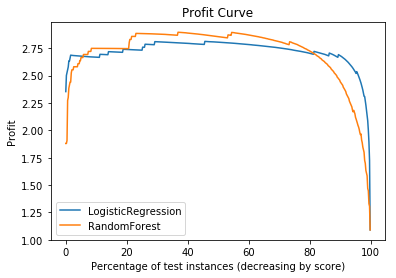

In [56]:
y_pred_prob = best_model.predict_proba(X_test)
y_pred = y_pred_prob[:,-1]
profs = profit_curve(np.array([[1998, -2],[0, 0]]), y_test.values, y_pred)
plt.plot(np.arange(0, 100, 100. / len(profs)), profs, label='LogisticRegression')

y_pred_prob = best_rf_model.predict_proba(X_test)
y_pred = y_pred_prob[:,-1]
profs = profit_curve(np.array([[1998, -2],[0, 0]]), y_test.values, y_pred)
plt.plot(np.arange(0, 100, 100. / len(profs)), profs, label='RandomForest')

plt.title("Profit Curve")
plt.xlabel("Percentage of test instances (decreasing by score)")
plt.ylabel("Profit")
plt.legend()
plt.show()

**As the profit curve shows, it's probably best to only target the very top 30 percentage which are
detected as "fraud" to maximize the profit**